In [1]:
using Pkg, NBInclude, Plots, XLSX, Dates, DataFrames, Random, Statistics
using DifferentialEquations, Sundials, ForwardDiff, Optim
using Distributions, ProgressMeter, Distributed, StaticArrays, LaTeXStrings
@nbinclude("ODE_models.ipynb")
@nbinclude("ODE_Param_Est.ipynb")
@nbinclude("ODE_Fit_IPN.ipynb")
@nbinclude("ODE_Fit.ipynb")
@nbinclude("HelperFunctions.ipynb")

data_to_df (generic function with 1 method)

In [2]:
#Generate random initial guesses which satisfy inequality constraints on betas & sigmas 
function func_get_x0(x_LBs, x_UBs)
    
    #x_LBs and x_UBs are arrays of (scaled) lower bounds and (scaled) upper bounds, respectively,
    x0 = x_LBs .+ (x_UBs .- x_LBs) .* rand(Float64,length(x_UBs))
    
    βSA = rand()
    βSI = (βSA / 3)*rand()
    τ₁ = 2 + 2*rand()         #τ₁ ∈ [2,4]
    if τ₁ ≤ 3
        τ₂ = (5 - τ₁) + (τ₁ - 2)*rand()
    else
        τ₂ = (5 - τ₁) + rand()
    end  
    σ₁ = 1/τ₁; σ₂ = 1/τ₂
    x0[1:4] = [βSA, βSI, σ₁, σ₂]
    return x0
end

func_get_x0 (generic function with 1 method)

In [ ]:
# a = collect(range(1,5, length = 19)) ./ 5
# b = collect(range(1,5, length = 19)) 

# Random.seed!(1234)
# n = 5
# vals = [func_get_x0(a,b) for i=1:n]

# Random.seed!(1234)
# vals = [func_get_x0(a,b) for i=1:n]

In [3]:
function Sim_Data_1age(data_obs)
    
    sim_data = DataFrame(Array{Float64}(undef, nrow(data_obs), ncol(data_obs)), names(data_obs))
    
    μ = 0.0; σ = 0.125
    trunc_norm = truncated(Normal(μ,σ), -0.99, Inf)
    
    sim_data[1,:] = data_obs[1,:]
    for i=2:nrow(data_obs)
        dᵢ = data_obs[i,:D] - data_obs[i-1,:D]    #daily new deaths
        hᵢ = data_obs[i,:Hc] - data_obs[i-1,:Hc]  #daily new hospitalizations
        ϵ = rand(trunc_norm, 2)                   #Note: This assumes that the reporting error for D and Hc are independent...
        sim_data[i,:] = (1 .+ ϵ) .* [dᵢ, hᵢ] .+ convert(Vector,sim_data[i-1,:])
    end
    return sim_data
end

Sim_Data_1age (generic function with 1 method)

In [4]:
function con_c!(c,x)
    c[1] = x[1]/3 - x[2]    
    c[2] = 1/x[3] + 1/x[4]  
end

function con_jac!(J,x)
    J[1,1] = 1/3
    J[1,2] = -1
    J[2,3] = -1/(x[3])^2
    J[2,4] = -1/(x[4])^2
end

function con_hess!(H, x, λ)
    H[3, 3] += λ[2] * 2 / x[3]^3
    H[4, 4] += λ[2] * 2 / x[4]^3
end

c_LBs = [0, 5]      # 0 ≤ BSA/3 - BSI ≤ 1/3
c_UBs = [1/3, 6]    # 5 ≤ 1/σ₁ + 1/σ₂ ≤ 6

cons = Dict(:con_func => con_c!, :con_jac => con_jac!, 
            :con_hess => con_hess!, :con_LBs => c_LBs,:con_UBs => c_UBs);                

In [5]:
path = "C:/Users/Michael/Documents/COVID-19/Mexico/Mexico_1age_params.xlsx"
ParIC_dict = Dict(:file_path => path, :param_sheet => "Params_2etas", :IC_sheet => "ICs");
Data_dict = Dict(:file_path => path, :data_sheet => "Obs_Data", :date_format => "mm-dd-yyyy");

In [10]:
int_options = Dict(:integrator => Tsit5(), :rtol => 1e-8, :atol => 1e-8);

optim_options = Dict(:xtol_abs => 0, :ftol_rel => 1e-4, :gtol_abs => 1e-8, :show_trace => false,
                     :show_every => 5, :max_iter => 1000, :max_time => 60);

save_options = Dict(:save_figs => false,  :save_params => true,
                    :figs_folder => "C:/Users/Michael/Documents/COVID-19/BS_plots/fit_100_exp2/",
                    :params_workbook => "C:/Users/Michael/Documents/COVID-19/BS_params.xlsx");

lin_weights = Array{Real,1}(fill(1.0, 101));
exp_weights = Array{Real,1}(exp.(collect(range(0.0, 3.0, length = 81))));

Optimizations in progress...  0%|█                                                 |  ETA: 6:56:57m

Sample 1 best min: 0.00991160383997941

Optimizations in progress...  1%|█                                                 |  ETA: 5:57:49

Optimizations in progress...  1%|█                                                 |  ETA: 4:44:49

Sample 2 best min: 0.012718470255486204


Optimizations in progress...  2%|█                                                 |  ETA: 4:40:31

Sample 3 best min: 0.012094867499503635

Optimizations in progress...  2%|█                                                 |  ETA: 4:27:11

Optimizations in progress...  2%|██                                                |  ETA: 4:20:10

Sample 4 best min: 0.006923726536286781


Optimizations in progress...  2%|██                                                |  ETA: 4:24:48

Sample 5 best min: 0.007660610075993047


Optimizations in progress...  3%|██                                                |  ETA: 4:19:17

Sample 6 best min: 0.00944659289499604


Optimizations in progress...  4%|██                                                |  ETA: 4:25:33

Sample 7 best min: 0.008234891882043146

Optimizations in progress...  4%|██                                                |  ETA: 4:19:31

Optimizations in progress...  4%|███                                               |  ETA: 4:30:09

Sample 8 best min: 0.008623007102633971


Optimizations in progress...  4%|███                                               |  ETA: 4:33:57

Sample 9 best min: 0.008756472100570883


Optimizations in progress...  5%|███                                               |  ETA: 4:35:44

Sample 10 best min: 0.010437151375185902

Optimizations in progress...  5%|███                                               |  ETA: 4:31:16

Optimizations in progress...  6%|███                                               |  ETA: 4:39:15

Sample 11 best min: 0.01072238644332564


Optimizations in progress...  6%|████                                              |  ETA: 4:52:42

Sample 12 best min: 0.011006209048346975


Optimizations in progress...  6%|████                                              |  ETA: 4:49:47

Sample 13 best min: 0.016808833855740852

Optimizations in progress...  7%|████                                              |  ETA: 4:46:17

Optimizations in progress...  7%|████                                              |  ETA: 4:37:11

Sample 14 best min: 0.010298487164143024


Optimizations in progress...  8%|████                                              |  ETA: 4:43:56

Sample 15 best min: 0.012069564922282238

Optimizations in progress...  8%|████                                              |  ETA: 4:40:42

Optimizations in progress...  8%|█████                                             |  ETA: 4:36:12

Sample 16 best min: 0.012139630335570663


Optimizations in progress...  8%|█████                                             |  ETA: 4:31:22

Sample 17 best min: 0.007539098360311091


Optimizations in progress...  9%|█████                                             |  ETA: 4:31:47

Sample 18 best min: 0.010331999958713995


Optimizations in progress... 10%|█████                                             |  ETA: 4:21:27

Sample 19 best min: 0.0081305383268736


Optimizations in progress... 10%|██████                                            |  ETA: 4:22:59

Sample 20 best min: 0.011445140296474105


Optimizations in progress... 10%|██████                                            |  ETA: 4:28:13

Sample 21 best min: 0.012188751951641189


Optimizations in progress... 11%|██████                                            |  ETA: 4:25:40

Sample 22 best min: 0.011533881474610248


Optimizations in progress... 12%|██████                                            |  ETA: 4:24:12

Sample 23 best min: 0.016038554705694968

Optimizations in progress... 12%|██████                                            |  ETA: 4:22:10

Optimizations in progress... 12%|███████                                           |  ETA: 4:21:12

Sample 24 best min: 0.011177589263339817


Optimizations in progress... 12%|███████                                           |  ETA: 4:15:59

Sample 25 best min: 0.009603677324847532

Optimizations in progress... 13%|███████                                           |  ETA: 4:14:06

Optimizations in progress... 13%|███████                                           |  ETA: 4:16:53

Sample 26 best min: 0.01143687603239906


Optimizations in progress... 14%|███████                                           |  ETA: 4:17:57

Sample 27 best min: 0.009310760141011266


Optimizations in progress... 14%|████████                                          |  ETA: 4:17:38

Sample 28 best min: 0.01297611258917543


Optimizations in progress... 14%|████████                                          |  ETA: 4:16:04

Sample 29 best min: 0.014817023451088339


Optimizations in progress... 15%|████████                                          |  ETA: 4:12:50

Sample 30 best min: 0.016156660535316357


Optimizations in progress... 16%|████████                                          |  ETA: 4:13:33

Sample 31 best min: 0.01012934122351546


Optimizations in progress... 16%|█████████                                         |  ETA: 4:12:15

Sample 32 best min: 0.007548130238082594


Optimizations in progress... 16%|█████████                                         |  ETA: 4:09:24

Sample 33 best min: 0.008557165538187523


Optimizations in progress... 17%|█████████                                         |  ETA: 4:08:57

Sample 34 best min: 0.012007287525042678


Optimizations in progress... 18%|█████████                                         |  ETA: 4:08:35

Sample 35 best min: 0.01202710182432732


Optimizations in progress... 18%|██████████                                        |  ETA: 4:04:55

Sample 36 best min: 0.008574423508670583


Optimizations in progress... 18%|██████████                                        |  ETA: 4:04:28

Sample 37 best min: 0.013295207864863514

Optimizations in progress... 19%|██████████                                        |  ETA: 4:03:08

Optimizations in progress... 19%|██████████                                        |  ETA: 4:01:27

Sample 38 best min: 0.011542178213520118


Optimizations in progress... 20%|██████████                                        |  ETA: 3:57:32

Sample 39 best min: 0.011411863211206602


Optimizations in progress... 20%|███████████                                       |  ETA: 3:55:14

Sample 40 best min: 0.008137982052200506

Optimizations in progress... 20%|███████████                                       |  ETA: 3:53:59

Optimizations in progress... 20%|███████████                                       |  ETA: 3:55:01

Sample 41 best min: 0.01087195436957377

Optimizations in progress... 21%|███████████                                       |  ETA: 3:53:46

Optimizations in progress... 21%|███████████                                       |  ETA: 3:53:36

Sample 42 best min: 0.010788486143570397


Optimizations in progress... 22%|███████████                                       |  ETA: 3:51:44

Sample 43 best min: 0.011786057180547854


Optimizations in progress... 22%|████████████                                      |  ETA: 3:50:18

Sample 44 best min: 0.012522994880984337


Optimizations in progress... 22%|████████████                                      |  ETA: 3:50:38

Sample 45 best min: 0.013248546236237675

Optimizations in progress... 23%|████████████                                      |  ETA: 3:49:34

Optimizations in progress... 23%|████████████                                      |  ETA: 3:47:25

Sample 46 best min: 0.008773841066948816

Optimizations in progress... 23%|████████████                                      |  ETA: 3:46:20

Optimizations in progress... 24%|████████████                                      |  ETA: 3:46:00

Sample 47 best min: 0.007882608631304857


Optimizations in progress... 24%|█████████████                                     |  ETA: 3:42:34

Sample 48 best min: 0.010028902819649464

Optimizations in progress... 24%|█████████████                                     |  ETA: 3:41:38

Optimizations in progress... 24%|█████████████                                     |  ETA: 3:41:37

Sample 49 best min: 0.01513858797174186


Optimizations in progress... 25%|█████████████                                     |  ETA: 3:38:21

Sample 50 best min: 0.00909935881190478

Optimizations in progress... 25%|█████████████                                     |  ETA: 3:37:23

Optimizations in progress... 26%|█████████████                                     |  ETA: 3:36:41

Sample 51 best min: 0.014792221088147017


Optimizations in progress... 26%|██████████████                                    |  ETA: 3:34:48

Sample 52 best min: 0.013463971024272891

Optimizations in progress... 26%|██████████████                                    |  ETA: 3:33:51

Optimizations in progress... 26%|██████████████                                    |  ETA: 3:32:27

Sample 53 best min: 0.014487297255226458

Optimizations in progress... 27%|██████████████                                    |  ETA: 3:31:30

Optimizations in progress... 27%|██████████████                                    |  ETA: 3:29:04

Sample 54 best min: 0.011192626193941096


Optimizations in progress... 28%|██████████████                                    |  ETA: 3:26:41

Sample 55 best min: 0.011206541859691097

Optimizations in progress... 28%|██████████████                                    |  ETA: 3:25:46

Optimizations in progress... 28%|███████████████                                   |  ETA: 3:25:21m

Sample 56 best min: 0.005816550419243123

Optimizations in progress... 28%|███████████████                                   |  ETA: 3:24:29

Optimizations in progress... 28%|███████████████                                   |  ETA: 3:22:03

Sample 57 best min: 0.009891317097342752

Optimizations in progress... 29%|███████████████                                   |  ETA: 3:21:12

Optimizations in progress... 29%|███████████████                                   |  ETA: 3:21:17

Sample 58 best min: 0.008599676264276265


Optimizations in progress... 30%|███████████████                                   |  ETA: 3:18:19

Sample 59 best min: 0.010888519496168233


Optimizations in progress... 30%|████████████████                                  |  ETA: 3:16:51

Sample 60 best min: 0.008204804686088921

Optimizations in progress... 30%|████████████████                                  |  ETA: 3:16:02

Optimizations in progress... 30%|████████████████                                  |  ETA: 3:16:08

Sample 61 best min: 0.010330602400462538


Optimizations in progress... 31%|████████████████                                  |  ETA: 3:15:33

Sample 62 best min: 0.009394270321085658


Optimizations in progress... 32%|████████████████                                  |  ETA: 3:14:52

Sample 63 best min: 0.01320194170213614

Optimizations in progress... 32%|████████████████                                  |  ETA: 3:14:07

Optimizations in progress... 32%|█████████████████                                 |  ETA: 3:12:22

Sample 64 best min: 0.01591103476939931


Optimizations in progress... 32%|█████████████████                                 |  ETA: 3:11:36

Sample 65 best min: 0.009076986205442093


Optimizations in progress... 33%|█████████████████                                 |  ETA: 3:08:40

Sample 66 best min: 0.013702327252504622


Optimizations in progress... 34%|█████████████████                                 |  ETA: 3:07:24

Sample 67 best min: 0.012815082069551415

Optimizations in progress... 34%|█████████████████                                 |  ETA: 3:06:41

Optimizations in progress... 34%|██████████████████                                |  ETA: 3:06:15

Sample 68 best min: 0.008665908403909716


Optimizations in progress... 34%|██████████████████                                |  ETA: 3:03:37

Sample 69 best min: 0.012803743953057545


Optimizations in progress... 35%|██████████████████                                |  ETA: 3:03:00

Sample 70 best min: 0.011611865344902763


Optimizations in progress... 36%|██████████████████                                |  ETA: 2:59:59

Sample 71 best min: 0.007070446465173293


Optimizations in progress... 36%|███████████████████                               |  ETA: 2:58:02

Sample 72 best min: 0.012232404895130193


Optimizations in progress... 36%|███████████████████                               |  ETA: 2:57:20

Sample 73 best min: 0.009754253916888242


Optimizations in progress... 37%|███████████████████                               |  ETA: 2:55:53

Sample 

Optimizations in progress... 37%|███████████████████                               |  ETA: 2:55:15

74 best min: 0.010331154917300932


Optimizations in progress... 38%|███████████████████                               |  ETA: 2:55:13

Sample 75 best min: 0.00876625811322402


Optimizations in progress... 38%|████████████████████                              |  ETA: 2:53:45

Sample 76 best min: 0.01116184148585958

Optimizations in progress... 38%|████████████████████                              |  ETA: 2:53:07

Optimizations in progress... 38%|████████████████████                              |  ETA: 2:52:19

Sample 77 best min: 0.011718781593935856

Optimizations in progress... 39%|████████████████████                              |  ETA: 2:51:43

Optimizations in progress... 39%|████████████████████                              |  ETA: 2:51:18

Sample 78 best min: 0.00893704109834577

Optimizations in progress... 39%|████████████████████                              |  ETA: 2:50:42

Optimizations in progress... 40%|████████████████████                              |  ETA: 2:50:30

Sample 79 best min: 0.010401316206088786


Optimizations in progress... 40%|█████████████████████                             |  ETA: 2:49:25

Sample 80 best min: 0.008685953213849162

Optimizations in progress... 40%|█████████████████████                             |  ETA: 2:48:50

Optimizations in progress... 40%|█████████████████████                             |  ETA: 2:48:02

Sample 81 best min: 0.01146046085275532


Optimizations in progress... 41%|█████████████████████                             |  ETA: 2:47:37

Sample 82 best min: 0.014581875356302964


Optimizations in progress... 42%|█████████████████████                             |  ETA: 2:45:30

Sample 83 best min: 0.013107748339506503


Optimizations in progress... 42%|██████████████████████                            |  ETA: 2:44:13

Sample 84 best min: 0.008944886037035709


Optimizations in progress... 42%|██████████████████████                            |  ETA: 2:43:13

Sample 85 best min: 0.00997360515200342


Optimizations in progress... 43%|██████████████████████                            |  ETA: 2:41:43

Sample 86 best min: 0.01030052350148102

Optimizations in progress... 43%|██████████████████████                            |  ETA: 2:41:09

Optimizations in progress... 44%|██████████████████████                            |  ETA: 2:41:05

Sample 87 best min: 0.011710331008290184


Optimizations in progress... 44%|███████████████████████                           |  ETA: 2:39:27

Sample 88 best min: 0.012355827914148092


Optimizations in progress... 44%|███████████████████████                           |  ETA: 2:38:41

Sample 89 best min: 0.011091164863518799

Optimizations in progress... 45%|███████████████████████                           |  ETA: 2:38:06

Optimizations in progress... 45%|███████████████████████                           |  ETA: 2:37:11

Sample 90 best min: 0.008916774129465743

Optimizations in progress... 45%|███████████████████████                           |  ETA: 2:36:37

Optimizations in progress... 46%|███████████████████████                           |  ETA: 2:35:37

Sample 91 best min: 0.008906729626342036

Optimizations in progress... 46%|███████████████████████                           |  ETA: 2:35:04

Optimizations in progress... 46%|████████████████████████                          |  ETA: 2:34:29

Sample 92 best min: 0.010670370185527384

Optimizations in progress... 46%|████████████████████████                          |  ETA: 2:33:58

Optimizations in progress... 46%|████████████████████████                          |  ETA: 2:32:45

Sample 93 best min: 0.011129630881342938


Optimizations in progress... 47%|████████████████████████                          |  ETA: 2:30:50

Sample 94 best min: 0.012963248911892742


Optimizations in progress... 48%|████████████████████████                          |  ETA: 2:28:40

Sample 95 best min: 0.014237968643989699


Optimizations in progress... 48%|█████████████████████████                         |  ETA: 2:26:23

Sample 96 best min: 0.014209083910647773


Optimizations in progress... 48%|█████████████████████████                         |  ETA: 2:24:37

Sample 97 best min: 0.009565343605220187

Optimizations in progress... 49%|█████████████████████████                         |  ETA: 2:24:06

Optimizations in progress... 49%|█████████████████████████                         |  ETA: 2:23:15

Sample 98 best min: 0.009544421551454633

Optimizations in progress... 49%|█████████████████████████                         |  ETA: 2:22:44

Optimizations in progress... 50%|█████████████████████████                         |  ETA: 2:21:20

Sample 99 best min: 0.011903671639568802


Optimizations in progress... 50%|██████████████████████████                        |  ETA: 2:19:58

Sample 100 best min: 0.012953233590796687

Optimizations in progress... 50%|██████████████████████████                        |  ETA: 2:19:27

Optimizations in progress... 50%|██████████████████████████                        |  ETA: 2:18:40

Sample 101 best min: 0.016417910296480057


Optimizations in progress... 51%|██████████████████████████                        |  ETA: 2:17:33

Sample 102 best min: 0.010121628510225435

Optimizations in progress... 51%|██████████████████████████                        |  ETA: 2:17:03

Optimizations in progress... 52%|██████████████████████████                        |  ETA: 2:16:08

Sample 103 best min: 0.008392689988808615

Optimizations in progress... 52%|██████████████████████████                        |  ETA: 2:15:39

Optimizations in progress... 52%|███████████████████████████                       |  ETA: 2:14:55

Sample 104 best min: 0.007470745804949126


Optimizations in progress... 52%|███████████████████████████                       |  ETA: 2:13:29

Sample 105 best min: 0.013934377940262588


Optimizations in progress... 53%|███████████████████████████                       |  ETA: 2:12:14

Sample 106 best min: 0.008962198921640087


Optimizations in progress... 54%|███████████████████████████                       |  ETA: 2:10:45

Sample 107 best min: 0.010605500655478677


Optimizations in progress... 54%|████████████████████████████                      |  ETA: 2:09:20

Sample 108 best min: 0.012028006659764171

Optimizations in progress... 54%|████████████████████████████                      |  ETA: 2:08:52

Optimizations in progress... 54%|████████████████████████████                      |  ETA: 2:07:35

Sample 109 best min: 0.010440402395795311


Optimizations in progress... 55%|████████████████████████████                      |  ETA: 2:06:09

Sample 110 best min: 0.010197189872773469


Optimizations in progress... 56%|████████████████████████████                      |  ETA: 2:04:55

Sample 111 best min: 0.010012909499968723

Optimizations in progress... 56%|████████████████████████████                      |  ETA: 2:04:29

Optimizations in progress... 56%|█████████████████████████████                     |  ETA: 2:03:43

Sample 112 best min: 0.01080314988449055


Optimizations in progress... 56%|█████████████████████████████                     |  ETA: 2:02:39

Sample 113 best min: 0.00954849862297244


Optimizations in progress... 57%|█████████████████████████████                     |  ETA: 2:01:03

Sample 114 best min: 0.008047655288425234


Optimizations in progress... 58%|█████████████████████████████                     |  ETA: 1:59:52

Sample 115 best min: 0.011905262323952628


Optimizations in progress... 58%|██████████████████████████████                    |  ETA: 1:58:06

Sample 116 best min: 0.01510840330716853


Optimizations in progress... 58%|██████████████████████████████                    |  ETA: 1:57:00

Sample 117 best min: 0.011315646111316018


Optimizations in progress... 59%|██████████████████████████████                    |  ETA: 1:55:40

Sample 118 best min: 0.007902069092282516


Optimizations in progress... 60%|██████████████████████████████                    |  ETA: 1:53:38

Sample 119 best min: 0.012214108399270885


Optimizations in progress... 60%|███████████████████████████████                   |  ETA: 1:52:20

Sample 120 best min: 0.009500579301254797


Optimizations in progress... 60%|███████████████████████████████                   |  ETA: 1:50:47

Sample 121 best min: 0.00923409249957296


Optimizations in progress... 61%|███████████████████████████████                   |  ETA: 1:49:02

Sample 122 best min: 0.011771685193530858

Optimizations in progress... 61%|███████████████████████████████                   |  ETA: 1:48:37

Optimizations in progress... 62%|███████████████████████████████                   |  ETA: 1:47:03

Sample 123 best min: 0.010395648982781992

Optimizations in progress... 62%|███████████████████████████████                   |  ETA: 1:46:39

Optimizations in progress... 62%|████████████████████████████████                  |  ETA: 1:46:06

Sample 124 best min: 0.01007441019194713

Optimizations in progress... 62%|████████████████████████████████                  |  ETA: 1:45:42

Optimizations in progress... 62%|████████████████████████████████                  |  ETA: 1:44:59

Sample 125 best min: 0.011989191499036284


Optimizations in progress... 63%|████████████████████████████████                  |  ETA: 1:43:38

Sample 126 best min: 0.007930511752931347


Optimizations in progress... 64%|████████████████████████████████                  |  ETA: 1:41:58

Sample 127 best min: 0.007361481033001488


Optimizations in progress... 64%|█████████████████████████████████                 |  ETA: 1:40:38

Sample 128 best min: 0.011057018643359902


Optimizations in progress... 64%|█████████████████████████████████                 |  ETA: 1:39:11

Sample 129 best min: 0.012886334852013619


Optimizations in progress... 65%|█████████████████████████████████                 |  ETA: 1:37:42

Sample 130 best min: 0.011326700714555021


Optimizations in progress... 66%|█████████████████████████████████                 |  ETA: 1:36:22

Sample 131 best min: 0.014080313174168343

Optimizations in progress... 66%|█████████████████████████████████                 |  ETA: 1:35:58

Optimizations in progress... 66%|██████████████████████████████████                |  ETA: 1:35:12

Sample 132 best min: 0.01458408750630917


Optimizations in progress... 66%|██████████████████████████████████                |  ETA: 1:33:27

Sample 133 best min: 0.010368239174566429


Optimizations in progress... 67%|██████████████████████████████████                |  ETA: 1:32:05

Sample 134 best min: 0.013295630387903575


Optimizations in progress... 68%|██████████████████████████████████                |  ETA: 1:30:40

Sample 135 best min: 0.0102985779333716


Optimizations in progress... 68%|███████████████████████████████████               |  ETA: 1:29:15

Sample 136 best min: 0.008561885057651038

Optimizations in progress... 68%|███████████████████████████████████               |  ETA: 1:28:52

Optimizations in progress... 68%|███████████████████████████████████               |  ETA: 1:27:39

Sample 137 best min: 0.010339238679152195


Optimizations in progress... 69%|███████████████████████████████████               |  ETA: 1:26:21

Sample 138 best min: 0.00915540245809019

Optimizations in progress... 69%|███████████████████████████████████               |  ETA: 1:25:58

Optimizations in progress... 70%|███████████████████████████████████               |  ETA: 1:24:37

Sample 139 best min: 0.016355619497650638


Optimizations in progress... 70%|████████████████████████████████████              |  ETA: 1:23:17

Sample 140 best min: 0.01422079720165605


Optimizations in progress... 70%|████████████████████████████████████              |  ETA: 1:21:58

Sample 141 best min: 0.009205016602792772


Optimizations in progress... 71%|████████████████████████████████████              |  ETA: 1:20:43

Sample 142 best min: 0.010048044769634255

Optimizations in progress... 71%|████████████████████████████████████              |  ETA: 1:20:21

Optimizations in progress... 72%|████████████████████████████████████              |  ETA: 1:19:20

Sample 143 best min: 0.013176156800173158

Optimizations in progress... 72%|████████████████████████████████████              |  ETA: 1:18:58

Optimizations in progress... 72%|█████████████████████████████████████             |  ETA: 1:17:48

Sample 144 best min: 0.007800680836337366

Optimizations in progress... 72%|█████████████████████████████████████             |  ETA: 1:17:26

Optimizations in progress... 72%|█████████████████████████████████████             |  ETA: 1:16:06

Sample 145 best min: 0.013246428166359386

Optimizations in progress... 73%|█████████████████████████████████████             |  ETA: 1:15:44

Optimizations in progress... 73%|█████████████████████████████████████             |  ETA: 1:14:34

Sample 146 best min: 0.009725435148618615


Optimizations in progress... 74%|█████████████████████████████████████             |  ETA: 1:13:10

Sample 147 best min: 0.010861928857310965


Optimizations in progress... 74%|██████████████████████████████████████            |  ETA: 1:11:43

Sample 148 best min: 0.01062250345135736

Optimizations in progress... 74%|██████████████████████████████████████            |  ETA: 1:11:22

Optimizations in progress... 74%|██████████████████████████████████████            |  ETA: 1:10:11

Sample 149 best min: 0.013676965768477253

Optimizations in progress... 75%|██████████████████████████████████████            |  ETA: 1:09:49

Optimizations in progress... 75%|██████████████████████████████████████            |  ETA: 1:08:38

Sample 150 best min: 0.009369106539372916

Optimizations in progress... 75%|██████████████████████████████████████            |  ETA: 1:08:17

Optimizations in progress... 76%|██████████████████████████████████████            |  ETA: 1:07:04

Sample 151 best min: 0.009866828492789638

Optimizations in progress... 76%|██████████████████████████████████████            |  ETA: 1:06:43

Optimizations in progress... 76%|███████████████████████████████████████           |  ETA: 1:05:42

Sample 152 best min: 0.007866620269961697

Optimizations in progress... 76%|███████████████████████████████████████           |  ETA: 1:05:21

Optimizations in progress... 76%|███████████████████████████████████████           |  ETA: 1:04:17

Sample 153 best min: 0.014174825219003087


Optimizations in progress... 77%|███████████████████████████████████████           |  ETA: 1:02:41

Sample 154 best min: 0.011521288141959705


Optimizations in progress... 78%|███████████████████████████████████████           |  ETA: 1:01:35

Sample 155 best min: 0.012786820193362861


Optimizations in progress... 78%|████████████████████████████████████████          |  ETA: 1:00:22

Sample 156 best min: 0.012379223522781174

Optimizations in progress... 78%|████████████████████████████████████████          |  ETA: 1:00:02

Optimizations in progress... 78%|████████████████████████████████████████          |  ETA: 0:58:58

Sample 157 best min: 0.009170499994268064


Optimizations in progress... 79%|████████████████████████████████████████          |  ETA: 0:57:27

Sample 158 best min: 0.014605713091006698


Optimizations in progress... 80%|████████████████████████████████████████          |  ETA: 0:55:51

Sample 159 best min: 0.012240250530623296


Optimizations in progress... 80%|█████████████████████████████████████████         |  ETA: 0:54:30

Sample 160 best min: 0.010018492220095689


Optimizations in progress... 80%|█████████████████████████████████████████         |  ETA: 0:53:04

Sample 161 best min: 0.012391144889232857

Optimizations in progress... 81%|█████████████████████████████████████████         |  ETA: 0:52:45

Optimizations in progress... 81%|█████████████████████████████████████████         |  ETA: 0:51:33

Sample 162 best min: 0.016489058661029142


Optimizations in progress... 82%|█████████████████████████████████████████         |  ETA: 0:50:10

Sample 163 best min: 0.00799928122602074


Optimizations in progress... 82%|██████████████████████████████████████████        |  ETA: 0:48:51

Sample 164 best min: 0.00910372801756569


Optimizations in progress... 82%|██████████████████████████████████████████        |  ETA: 0:47:25

Sample 165 best min: 0.008444972725095975


Optimizations in progress... 83%|██████████████████████████████████████████        |  ETA: 0:46:09

Sample 166 best min: 0.007624516495780288

Optimizations in progress... 83%|██████████████████████████████████████████        |  ETA: 0:45:49

Optimizations in progress... 84%|██████████████████████████████████████████        |  ETA: 0:44:42

Sample 167 best min: 0.010554423606752173


Optimizations in progress... 84%|███████████████████████████████████████████       |  ETA: 0:43:17

Sample 168 best min: 0.009615833820508731


Optimizations in progress... 84%|███████████████████████████████████████████       |  ETA: 0:42:00

Sample 169 best min: 0.010788146851635743

Optimizations in progress... 85%|███████████████████████████████████████████       |  ETA: 0:41:41

Optimizations in progress... 85%|███████████████████████████████████████████       |  ETA: 0:40:45

Sample 170 best min: 0.012324534183841898


Optimizations in progress... 86%|███████████████████████████████████████████       |  ETA: 0:39:27

Sample 171 best min: 0.012427639152475793


Optimizations in progress... 86%|████████████████████████████████████████████      |  ETA: 0:38:12

Sample 172 best min: 0.009814601003214324

Optimizations in progress... 86%|████████████████████████████████████████████      |  ETA: 0:37:53

Optimizations in progress... 86%|████████████████████████████████████████████      |  ETA: 0:36:44

Sample 173 best min: 0.00971083780039424

Optimizations in progress... 87%|████████████████████████████████████████████      |  ETA: 0:36:26

Optimizations in progress... 87%|████████████████████████████████████████████      |  ETA: 0:35:19

Sample 174 best min: 0.00967064332129539


Optimizations in progress... 88%|████████████████████████████████████████████      |  ETA: 0:33:51

Sample 175 best min: 0.013994179915466417


Optimizations in progress... 88%|█████████████████████████████████████████████     |  ETA: 0:32:28

Sample 176 best min: 0.012575999145934278


Optimizations in progress... 88%|█████████████████████████████████████████████     |  ETA: 0:31:05

Sample 177 best min: 0.009588356686104138


Optimizations in progress... 89%|█████████████████████████████████████████████     |  ETA: 0:29:47

Sample 178 best min: 0.013064693641480253

Optimizations in progress... 89%|█████████████████████████████████████████████     |  ETA: 0:29:29

Optimizations in progress... 90%|█████████████████████████████████████████████     |  ETA: 0:28:24

Sample 179 best min: 0.010494913242214483


Optimizations in progress... 90%|██████████████████████████████████████████████    |  ETA: 0:27:03

Sample 180 best min: 0.014161419451041893


Optimizations in progress... 90%|██████████████████████████████████████████████    |  ETA: 0:25:47

Sample 181 best min: 0.010183394608914622

Optimizations in progress... 91%|██████████████████████████████████████████████    |  ETA: 0:25:29

Optimizations in progress... 91%|██████████████████████████████████████████████    |  ETA: 0:24:27

Sample 182 best min: 0.009344210294530211


Optimizations in progress... 92%|██████████████████████████████████████████████    |  ETA: 0:23:05

Sample 183 best min: 0.010406260816948459


Optimizations in progress... 92%|███████████████████████████████████████████████   |  ETA: 0:21:46

Sample 184 best min: 0.00846846720347874

Optimizations in progress... 92%|███████████████████████████████████████████████   |  ETA: 0:21:29

Optimizations in progress... 92%|███████████████████████████████████████████████   |  ETA: 0:20:22

Sample 185 best min: 0.013755180317528749


Optimizations in progress... 93%|███████████████████████████████████████████████   |  ETA: 0:18:56

Sample 186 best min: 0.018021889413241787


Optimizations in progress... 94%|███████████████████████████████████████████████   |  ETA: 0:17:36

Sample 187 best min: 0.008897023510133027


Optimizations in progress... 94%|████████████████████████████████████████████████  |  ETA: 0:16:17

Sample 188 best min: 0.011107379421273524

Optimizations in progress... 94%|████████████████████████████████████████████████  |  ETA: 0:16:00

Optimizations in progress... 94%|████████████████████████████████████████████████  |  ETA: 0:14:56

Sample 189 best min: 0.011621324256930143


Optimizations in progress... 95%|████████████████████████████████████████████████  |  ETA: 0:13:34

Sample 190 best min: 0.015903804138541356


Optimizations in progress... 96%|████████████████████████████████████████████████  |  ETA: 0:12:13

Sample 191 best min: 0.01260260036774925


Optimizations in progress... 96%|█████████████████████████████████████████████████ |  ETA: 0:10:50

Sample 192 best min: 0.01049840641802002

Optimizations in progress... 96%|█████████████████████████████████████████████████ |  ETA: 0:10:33

Optimizations in progress... 96%|█████████████████████████████████████████████████ |  ETA: 0:09:30

Sample 193 best min: 0.012364876648207717


Optimizations in progress... 97%|█████████████████████████████████████████████████ |  ETA: 0:08:09

Sample 194 best min: 0.011698035337285941

Optimizations in progress... 97%|█████████████████████████████████████████████████ |  ETA: 0:07:52

Optimizations in progress... 98%|█████████████████████████████████████████████████ |  ETA: 0:06:46

Sample 195 best min: 0.009577976945366629

Optimizations in progress... 98%|█████████████████████████████████████████████████ |  ETA: 0:06:30

Optimizations in progress... 98%|██████████████████████████████████████████████████|  ETA: 0:05:24

Sample 196 best min: 0.011496003610022086


Optimizations in progress... 98%|██████████████████████████████████████████████████|  ETA: 0:04:03

Sample 197 best min: 0.013523156525824812


Optimizations in progress... 99%|██████████████████████████████████████████████████|  ETA: 0:02:42

Sample 198 best min: 0.012598193226143983


Optimizations in progress...100%|██████████████████████████████████████████████████|  ETA: 0:01:21

Sample 199 best min: 0.009733781064640517

Optimizations in progress...100%|██████████████████████████████████████████████████|  ETA: 0:01:05

Optimizations in progress...100%|██████████████████████████████████████████████████| Time: 4:30:20


Sample 200 best min: 0.011438734640701009


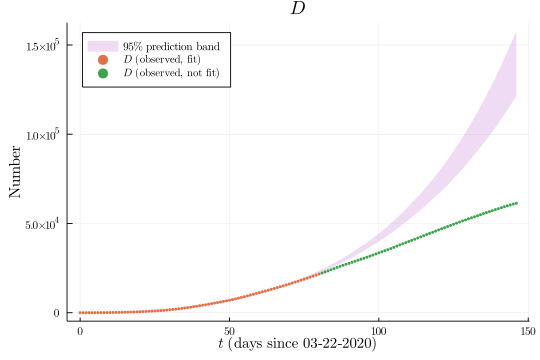

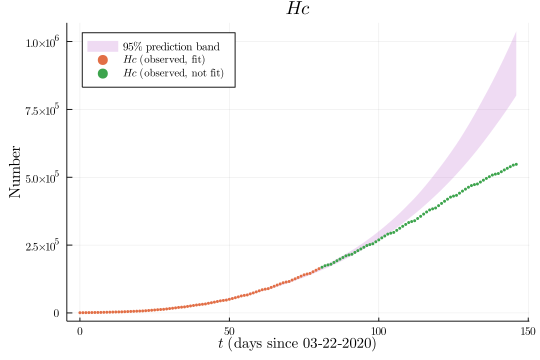


Total optimization time: 16221.0 seconds
Average time per optimization: 16.22 seconds

Number of autodiff fails: 0

19×6 DataFrame
 Row │ Parameter    2.5          25.0         50.0         75.0         97.5         
     │ String       Float64      Float64      Float64      Float64      Float64      
─────┼───────────────────────────────────────────────────────────────────────────────
   1 │ \\beta_{SA}    0.293348     0.341086     0.372267     0.400379      0.493952
   2 │ \\beta_{SI}    0.0071461    0.0267779    0.0399912    0.0515781     0.097034
   3 │ \\sigma_1      0.279039     0.337186     0.372689     0.425885      0.490297
   4 │ \\sigma_2      0.334535     0.355651     0.397885     0.433686      0.632694
   5 │ \\varphi       0.11132      0.162799     0.186569     0.222821      0.298418
   6 │ M              0.0892979    0.114625     0.132399     0.155747      0.230411
   7 │ M_{AR}         0.0857002    0.109848     0.124662     0.145021      0.166408
   8 │ \\gamma        

In [9]:
out = ODE_Param_Est(;ODE_model = OneAgeModel!,
                     ODE_vars = [:S, :E, :P, :A, :AR, :I, :H, :R, :D, :Hc],
                     vars_to_fit = [:D, :Hc],
                     paramIC_dict = ParIC_dict,
                     data_dict = Data_dict, 
                     f_calc_ICs = f_ICs,
                     func_sim_data = Sim_Data_1age,
                     fit_range = ["03-22-2020","6-10-2020"], 
                     date_obs_last = "08-15-2020", 
                     forecast_until = "08-15-2020", 
                     N0 = 127575528.0,
                     norm = mean_square_rel_error, 
                     norm_weights = exp_weights,
                     norm_scale = 1.0,
                     optimizer = IPNewton,
                     constraints = cons,
                     func_get_x0 = func_get_x0,
                     BS_samples = 200,  
                     num_x0 = 5,
                     pred_band_pct = 95,
                     x_pctiles = [2.5, 25.0, 50.0, 75.0, 97.5],
                     integrator_options = int_options, 
                     optimizer_options = optim_options,
                     save_options = save_options);

In [23]:
x = out.minimizers_df



quantile( 1 ./ x."\\psi", [0.025, .25, .50, .75, .975])

5-element Array{Float64,1}:
  5.039449670865512
  5.676189817781391
  9.104486021031931
 10.471896270248157
 13.375070123828586